In [2]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.tools.python.tool import PythonAstREPLTool
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END

# API 키 정보 로드
load_dotenv()

True

In [3]:
from typing import Annotated


# Tavily 검색 도구 정의
tavily_tool = TavilySearchResults()

# Python 코드를 실행하는 도구 정의
python_repl = PythonAstREPLTool()


# Python 코드를 실행하는 도구 정의
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        # 주어진 코드를 Python REPL에서 실행하고 결과 반환
        result = python_repl.run(code)
    except BaseException as e:
        return f"Failed to execute code. Error: {repr(e)}"
    # 실행 성공 시 결과와 함께 성공 메시지 반환
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )


In [4]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )


In [5]:
# 상태 정의
class AgentState(TypedDict):
    messages: Annotated[
        Sequence[BaseMessage], operator.add
    ]  # Agent 간 공유하는 메시지 목록
    sender: Annotated[str, "The sender of the last message"]  # 마지막 메시지의 발신자

In [6]:
# LLM 정의
llm = ChatOpenAI(model="gpt-4o-mini")

# Research Agent 생성
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    state_modifier=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


# Research Agent 노드 정의
def research_node(state: MessagesState) -> MessagesState:
    result = research_agent.invoke(state)

    # 마지막 메시지를 HumanMessage 로 변환
    last_message = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return {
        # Research Agent 의 메시지 목록 반환
        "messages": [last_message],
    }


In [7]:
# Research Agent 노드 정의
def research_node(state: MessagesState) -> MessagesState:
    result = research_agent.invoke(state)

    # 마지막 메시지를 HumanMessage 로 변환
    last_message = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return {
        # Research Agent 의 메시지 목록 반환
        "messages": [last_message],
    }

In [8]:
chart_generator_system_prompt = """
You can only generate charts. You are working with a researcher colleague.
Be sure to use the following font code in your code when generating charts.
"""

# Chart Generator Agent 생성
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    state_modifier=make_system_prompt(chart_generator_system_prompt),
)


In [9]:
def chart_node(state: MessagesState) -> MessagesState:
    result = chart_agent.invoke(state)

    # 마지막 메시지를 HumanMessage 로 변환
    last_message = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return {
        # share internal message history of chart agent with other agents
        "messages": [last_message],
    }


In [10]:
def router(state: MessagesState):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return "continue"


In [11]:
from langchain_core.messages import HumanMessage, ToolMessage
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_conditional_edges(
    "researcher",
    router,
    {"continue": "chart_generator", END: END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "researcher", END: END},
)

workflow.add_edge(START, "researcher")
app = workflow.compile(checkpointer=MemorySaver())


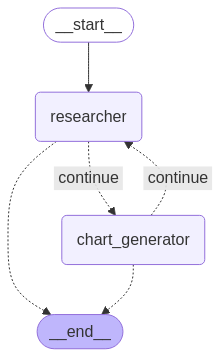

In [12]:
app

In [15]:
from langchain_core.runnables import RunnableConfig

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": "abc123"})

# 질문 입력
inputs = {
    "messages": [
        HumanMessage(
            content="2010년 ~ 2024년까지의 대한민국의 1인당 GDP 추이를 그래프로 시각화 해주세요."
        )
    ],
}



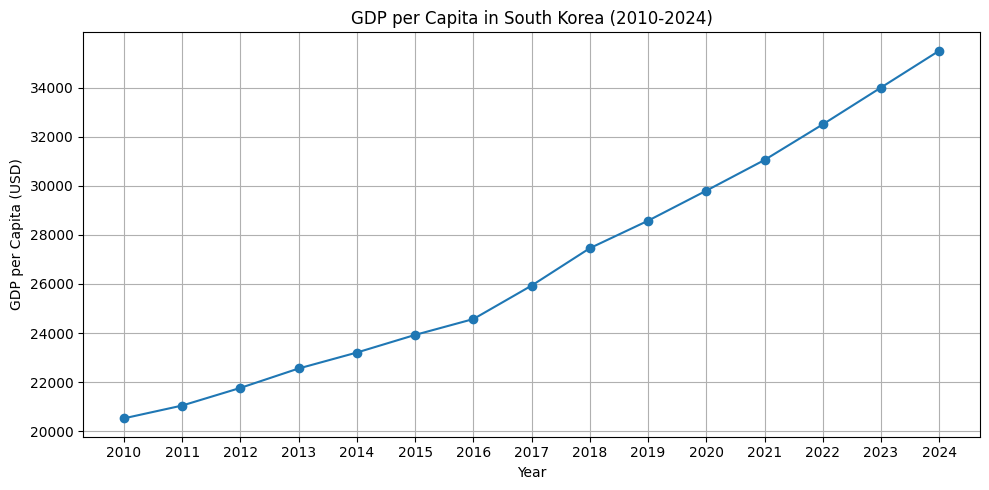

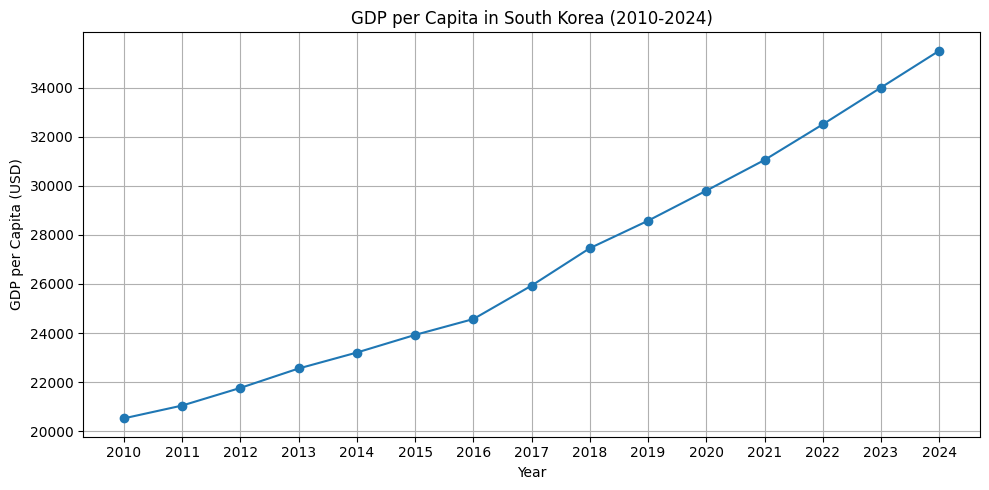

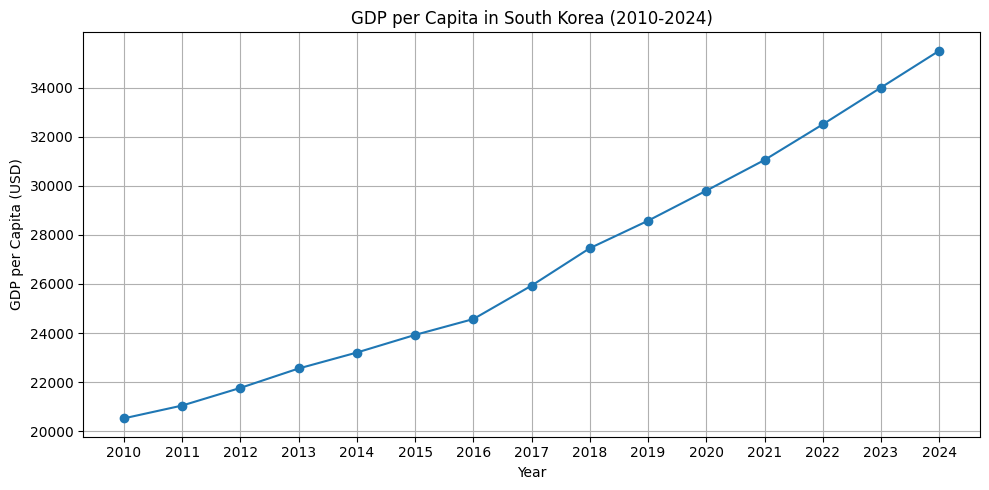

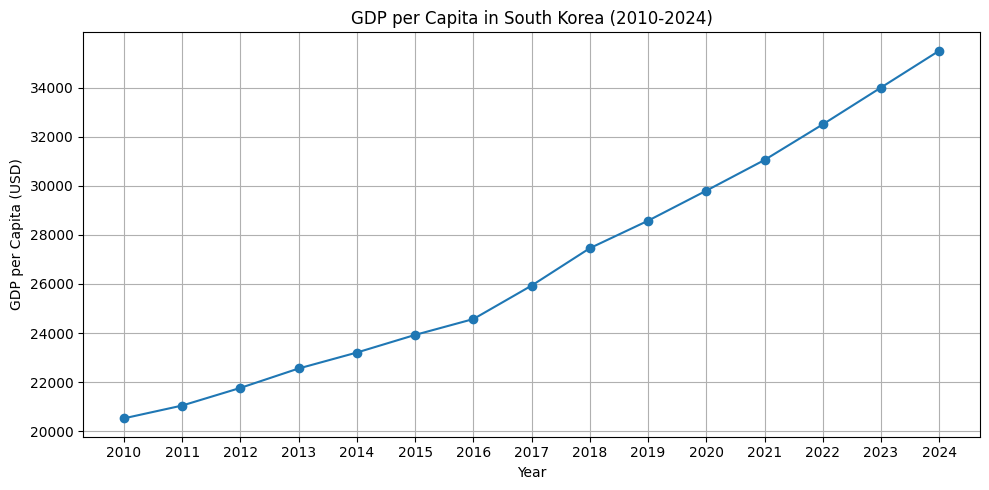

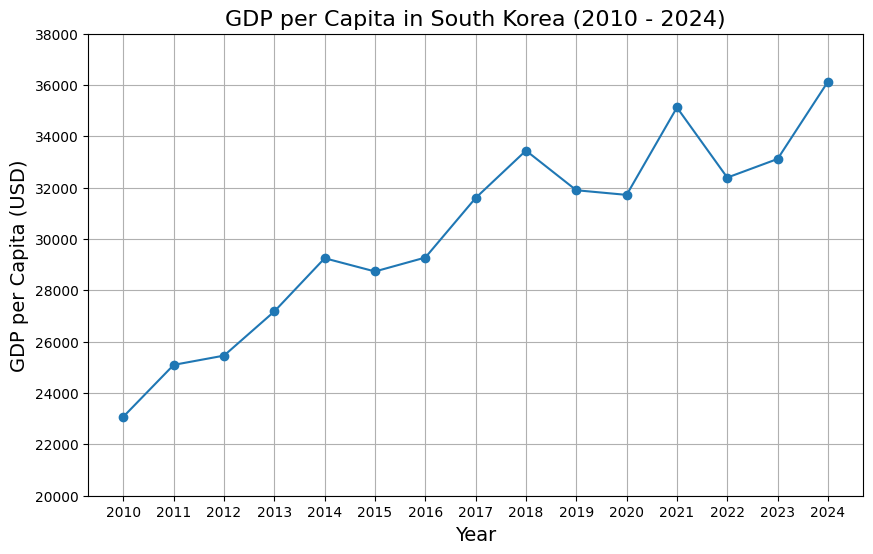

In [19]:
result = app.invoke(inputs, config=config)

In [20]:
result

{'messages': [HumanMessage(content='2010년 ~ 2024년까지의 대한민국의 1인당 GDP 추이를 그래프로 시각화 해주세요.', additional_kwargs={}, response_metadata={}, id='fcf12d92-e093-4b9a-9dd1-1c9d50c71bdd'),
  HumanMessage(content='Since I am not equipped to create charts directly, I recommend using one of the following online tools to visualize the GDP per capita data:\n\n1. **[ChartGo](https://www.chartgo.com/home.html)**: A free and easy-to-use tool for creating various types of graphs.\n2. **[Meta-Chart](https://www.meta-chart.com/)**: Allows you to create custom pie, bar, spline, line, and area charts.\n3. **[Adobe Express Chart Maker](https://www.adobe.com/express/create/chart)**: Provides templates to quickly create professional-looking charts.\n4. **[QuickChart](https://quickchart.io/chart-maker/)**: An online no-code chart maker for building interactive charts.\n\nYou can input the data provided earlier to create a graph visualizing the GDP per capita in South Korea from 2010 to 2023. If you need further ass